 # Image Captioning with Conditioned LSTM Generators
## Xinyi Le

Specifically, We will build the following components in this project: 

* Create matrices of image representations using an off-the-shelf image encoder.
* Read and preprocess the image captions. 
* Write a generator function that returns one training instance (input/output sequence pair) at a time. 
* Train an LSTM language generator on the caption data.
* Write a decoder function for the language generator. 
* Add the image input to write an LSTM caption generator. 
* Implement beam search for the image caption generator.

### Getting Started 

First, run the following commands to make sure we have all required packages. 

In [1]:
import os
from collections import defaultdict
import numpy as np
import PIL
from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from tensorflow.keras.activations import softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam

from google.colab import drive

### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html when discussing our results

In [2]:
#this is where we put the name of your data folder.
my_data_dir="hw5_data"

### Mounting your GDrive so you can access the files from Colab

In [3]:
#running this command will generate a message that will ask you to click on a link where you'll obtain your GDrive auth code.
drive.mount('/content/gdrive')

## Part I: Image Encodings (14 pts)

The files Flickr_8k.trainImages.txt Flickr_8k.devImages.txt Flickr_8k.testImages.txt, contain a list of training, development, and test images, respectively. Let's load these lists. 

In [4]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]    

In [5]:
train_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.trainImages.txt')
dev_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.devImages.txt')
test_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.testImages.txt')

Let's see how many images there are

In [6]:
len(train_list), len(dev_list), len(test_list)

(6000, 1000, 1000)

Each entry is an image filename.

In [7]:
dev_list[20]

'3693961165_9d6c333d5b.jpg'

The images are located in a subdirectory.  

In [8]:
IMG_PATH = '/content/gdrive/My Drive/'+my_data_dir+"/Flickr8k_Dataset"

We can use PIL to open the image and matplotlib to display it. 

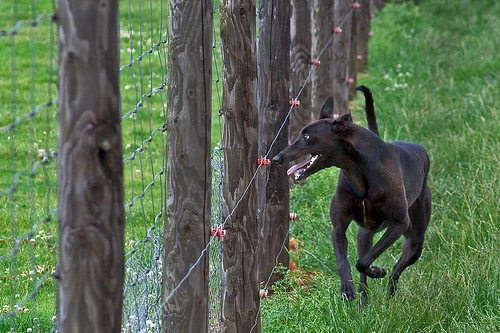

In [9]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[20]))
image

if you can't see the image, try

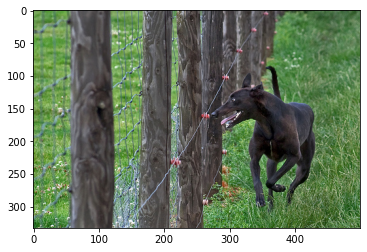

In [10]:
plt.imshow(image)

We are going to use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolution neural network for object detection. Here is more detail about this model (not required for this project): 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model requires that input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [11]:
np.asarray(image).shape

(333, 500, 3)

The values range from 0 to 255. 

In [12]:
np.asarray(image)

array([[[118, 161,  89],
        [120, 164,  89],
        [111, 157,  82],
        ...,
        [ 68, 106,  65],
        [ 64, 102,  61],
        [ 65, 104,  60]],

       [[125, 168,  96],
        [121, 164,  92],
        [119, 165,  90],
        ...,
        [ 72, 115,  72],
        [ 65, 108,  65],
        [ 72, 115,  70]],

       [[129, 175, 102],
        [123, 169,  96],
        [115, 161,  88],
        ...,
        [ 88, 129,  87],
        [ 75, 116,  72],
        [ 75, 116,  72]],

       ...,

       [[ 41, 118,  46],
        [ 36, 113,  41],
        [ 45, 111,  49],
        ...,
        [ 23,  77,  15],
        [ 60, 114,  62],
        [ 19,  59,   0]],

       [[100, 158,  97],
        [ 38, 100,  37],
        [ 46, 117,  51],
        ...,
        [ 25,  54,   8],
        [ 88, 112,  76],
        [ 65, 106,  48]],

       [[ 89, 148,  84],
        [ 44, 112,  35],
        [ 71, 130,  72],
        ...,
        [152, 188, 142],
        [113, 151, 110],
        [ 94, 138,  75]]

We can use PIL to resize the image and then divide every value by 255. 

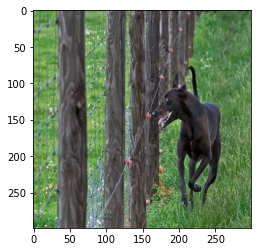

In [13]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [14]:
new_image.shape

(299, 299, 3)

Let's put this all in a function for convenience. 

In [15]:
def get_image(image_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, image_name))
    return np.asarray(image.resize((299,299))) / 255.0                      

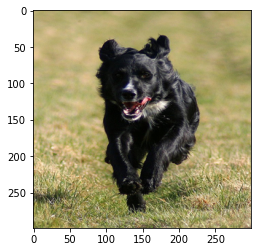

In [16]:
plt.imshow(get_image(dev_list[25]))

Next, we load the pre-trained Inception model. 

In [17]:
img_model = InceptionV3(weights='imagenet') # This will download the weight files for you and might take a while.

2022-04-24 08:21:06.068372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-24 08:21:06.068797: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [18]:
img_model.summary() # this is quite a complex model. 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 17, 17, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

We will use the following hack: hook up the input into a new Keras model and use the penultimate layer of the existing model as output.

In [19]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output) # This is the final Keras image encoder model we will use.

Let's try the encoder. 

In [20]:
encoded_image = img_encoder.predict(np.array([new_image]))

2022-04-24 08:21:07.612534: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-24 08:21:07.931102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [21]:
encoded_image

array([[0.63806677, 0.48873085, 0.05526239, ..., 0.64255744, 0.2959525 ,
        0.4900437 ]], dtype=float32)

We will need to create encodings for all images and store them in one big matrix (one for each dataset, train, dev, test).
We can then save the matrices so that we never have to touch the bulky image data again. 

To save memory (but slow the process down a little bit) we will read in the images lazily using a generator. We will encounter generators again later when we train the LSTM.

In [22]:
def img_generator(img_list):
#     #...
#     yield #...
    for img in img_list:
        image = get_image(img)
        yield np.array([image])

Now we can encode all images (this takes a few minutes).

In [23]:
enc_train = img_encoder.predict_generator(img_generator(train_list), steps=len(train_list), verbose=1)

/var/folders/9c/8xqmyjf50gbfzlbpc6hltlph0000gq/T/ipykernel_95459/1546781009.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  enc_train = img_encoder.predict_generator(img_generator(train_list), steps=len(train_list), verbose=1)
2022-04-24 08:21:08.669754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6000/6000 [==============================] - 100s 17ms/step


In [24]:
enc_train[11]

array([0.26818636, 1.0321658 , 0.5851626 , ..., 1.2316744 , 0.17969248,
       0.22405228], dtype=float32)

In [25]:
enc_dev = img_encoder.predict_generator(img_generator(dev_list), steps=len(dev_list), verbose=1)

   2/1000 [..............................] - ETA: 1:47

/var/folders/9c/8xqmyjf50gbfzlbpc6hltlph0000gq/T/ipykernel_95459/2004919006.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  enc_dev = img_encoder.predict_generator(img_generator(dev_list), steps=len(dev_list), verbose=1)


1000/1000 [==============================] - 17s 17ms/step


In [26]:
enc_test = img_encoder.predict_generator(img_generator(test_list), steps=len(test_list), verbose=1)

  10/1000 [..............................] - ETA: 17s

/var/folders/9c/8xqmyjf50gbfzlbpc6hltlph0000gq/T/ipykernel_95459/1458876446.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  enc_test = img_encoder.predict_generator(img_generator(test_list), steps=len(test_list), verbose=1)


1000/1000 [==============================] - 17s 17ms/step


It's a good idea to save the resulting matrices, so we do not have to run the encoder again. 

In [27]:
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_train.npy", enc_train)
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_dev.npy", enc_dev)
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_test.npy", enc_test)

## Part II Text (Caption) Data Preparation (14 pts)

Next, we need to load the image captions and generate training data for the generator model.

### Reading image descriptions

The captions in the file are already tokenized, so we can just split them at white spaces. We should convert each token to lower case. We should then pad each caption with a START token on the left and an END token on the right. 

In [28]:
def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)    
    # ...
    with open(filename,'r') as image_list_f: 
        for line in image_list_f:
            name, tokens = line.split("\t")
            name = name[:-2]
            
            val_split = tokens.split(" ")
            
            value = val_split[: -1]
            value.append(val_split[-1][:-1])
            # convert each token to lower case
            value = [val.lower() for val in value]
            
            # add start and end token to list
            value = ["<START>"] + value + ["<END>"]

            
            image_descriptions[name].append(value)
    return image_descriptions

In [29]:
descriptions = read_image_descriptions("gdrive/My Drive/"+my_data_dir+"/Flickr8k.token.txt")

In [30]:
print(descriptions[dev_list[0]])

[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]


Running the previous cell should print:     
`[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]
`    

### Creating Word Indices

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input 
and output sequences using numeric representations. 

In [31]:
token_set = set()
for i in range(len(train_list)):
    token_list = descriptions[train_list[i]]
    for l in token_list:
        for token in l:
            token_set.add(token)
token_ls = sorted(list(token_set))
ids = list(range(len(token_ls)))

id_to_word = {}
for i in range(len(ids)):
    id_to_word[ids[i]] = token_ls[i]

In [32]:
word_to_id = {}
for i in range(len(token_ls)):
    word_to_id[token_ls[i]] = ids[i]

In [33]:
word_to_id['dog'] # should print an integer

1985

In [34]:
word_to_id['<START>']

59

In [35]:
id_to_word[1985] # should print a token

'dog'

Note that we do not need an UNK word token because we are generating. The generated text will only contain tokens seen at training time.  

## Part III Basic Decoder Model (24 pts)

For now, we will just train a model for text generation without conditioning the generator on the image input. 

There are different ways to do this and our approach will be slightly different from the generator discussed in class. 

The core idea here is that the Keras recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [36]:
max(len(description) for image_id in train_list for description in descriptions[image_id])

40

Here is LSTM generators as transducers that map each word in the input sequence to the next word. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm1.png" width="480px">

Instead, we will use the model to predict one word at a time, given a partial sequence. For example, given the sequence ["START","a"], the model might predict "dog" as the most likely word. We are basically using the LSTM to encode the input sequence up to this point. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm2.png" width="480px">


To train the model, we will convert each description into a set of input output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '.', '<END>']`

We would train the model using the following input/output pairs 

| i | input                        | output |
|---|------------------------------|--------|
| 0 |[`START`]                     | `a`    |  
| 1 |[`START`,`a`]                 | `black`|
| 2 |[`START`,`a`, `black`]        | `dog`  |
| 3 |[`START`,`a`, `black`, `dog`] | `END`  |



Here is the model in Keras Keras. Note that we are using a Bidirectional LSTM, which encodes the sequence from both directions and then predicts the output. 
Also note the `return_sequence=False` parameter, which causes the LSTM to return a single output instead of one output per state. 

Note also that we use an embedding layer for the input words. The weights are shared between all units of the unrolled LSTM. We will train these embeddings with the model. 

In [37]:
MAX_LEN = 40
EMBEDDING_DIM=300
vocab_size = len(word_to_id)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Bidirectional(LSTM(512, return_sequences=False))(embedding)
pred = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 300)           2312100   
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             3330048   
 l)                                                              
                                                                 
 dense (Dense)               (None, 7707)              7899675   
                                                                 
Total params: 13,541,823
Trainable params: 13,541,823
Non-trainable params: 0
_________________________________________________________________


The model input is a numpy ndarray (a tensor) of size `(batch_size, MAX_LEN)`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with 0. 

For each input example, the model returns a softmax activated vector (a probability distribution) over possible output words. The model output is a numpy ndarray of size `(batch_size, vocab_size)`. vocab_size is the number of vocabulary words. 

### Creating a Generator for the Training Data

We could simply create one large numpy ndarray for all the training data. Because we have a lot of training instances (each training sentence will produce up to MAX_LEN input/output pairs, one for each word), it is better to produce the training examples *lazily*, i.e. in batches using a generator (recall the image generator in part I). 


In [38]:
def text_training_generator(batch_size=128):
    res_inp = []
    res_out = []
    while True:
        # for every image in train_list, we get a list of descriptions
        for name in train_list:
            des_list = descriptions[name]
            
            # for every description, we get multiple model inputs and outputs
            for ls in des_list:
                for i in range(len(ls)-1):
                    inp, out = ls[:i+1], ls[i+1]
                    final_inp, final_out = [0] * MAX_LEN, [0] * vocab_size
                    
                    for i in range(len(inp)):
                        final_inp[i] = word_to_id[inp[i]]
                        
                    final_out[word_to_id[out]] = 1
                    # add model input and output to our list
                    res_inp.append(final_inp)
                    res_out.append(final_out)
                    
                    # if list length equals to batch size, generate it
                    if len(res_inp) == batch_size:
                        yield (np.array(res_inp), np.array(res_out))
                        res_inp = []
                        res_out = []

In [39]:
next(text_training_generator())[1].shape

(128, 7707)

### Training the Model

We will use the `fit_generator` method of the model to train the model. fit_generator needs to know how many iterator steps there are per epoch.

Because there are len(train_list) training samples with up to `MAX_LEN` words, an upper bound for the number of total training instances is `len(train_list)*MAX_LEN`. Because the generator returns these in batches, the number of steps is len(train_list) * MAX_LEN // batch_size

In [40]:
batch_size = 128
generator = text_training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [41]:
model.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=10)

Epoch 1/10


/var/folders/9c/8xqmyjf50gbfzlbpc6hltlph0000gq/T/ipykernel_95459/1325548833.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=10)
2022-04-24 08:23:26.367504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 08:23:26.661355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 08:23:26.671998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 08:23:26.863227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 08:23:26.879081: I tensorflow/core/grappler/optimizers/custom_gra

1875/1875 [==============================] - 198s 105ms/step - loss: 4.2516 - accuracy: 0.2968
Epoch 2/10
1875/1875 [==============================] - 194s 104ms/step - loss: 3.6895 - accuracy: 0.3585
Epoch 3/10
1875/1875 [==============================] - 195s 104ms/step - loss: 3.5220 - accuracy: 0.3747
Epoch 4/10
1875/1875 [==============================] - 195s 104ms/step - loss: 3.4194 - accuracy: 0.3840
Epoch 5/10
1875/1875 [==============================] - 194s 103ms/step - loss: 3.3624 - accuracy: 0.3901
Epoch 6/10
1875/1875 [==============================] - 194s 103ms/step - loss: 3.2946 - accuracy: 0.3958
Epoch 7/10
1875/1875 [==============================] - 197s 105ms/step - loss: 3.2846 - accuracy: 0.3984
Epoch 8/10
1875/1875 [==============================] - 212s 113ms/step - loss: 3.2850 - accuracy: 0.3999
Epoch 9/10
1875/1875 [==============================] - 212s 113ms/step - loss: 3.2739 - accuracy: 0.4055
Epoch 10/10
1875/1875 [==============================] - 

Continue to train the model until you reach an accuracy of at least 40%. 

### Greedy Decoder

Next, we will write a decoder. The decoder should start with the sequence `["<START>"]`, use the model to predict the most likely word, append the word to the sequence and then continue until `"<END>"` is predicted or the sequence reaches `MAX_LEN` words. 

In [42]:
def decoder():
    res = ["<START>"]
    while res[-1] != "<END>" and len(res) < 40:
        inp = [0] * MAX_LEN
        for i in range(len(res)):
            inp[i] = word_to_id[res[i]]
        out = model.predict(np.array(inp).reshape((-1, MAX_LEN)))
        next_token = id_to_word[out.argmax()]
        res.append(next_token)
    return res

In [43]:
print(decoder())

2022-04-24 08:56:47.860890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 08:56:47.946087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 08:56:47.954584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


['<START>', 'a', 'man', 'and', 'woman', 'are', 'walking', 'on', 'the', 'beach', '.', '<END>']


This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

Modify the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. Take a look at the [np.random.multinomial](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multinomial.html) function to do this. 

In [44]:
def sample_decoder():
    res = ["<START>"]
    while res[-1] != "<END>" and len(res) < 40:
        inp = [0] * MAX_LEN
        for i in range(len(res)):
            inp[i] = word_to_id[res[i]]
        out = model.predict(np.array(inp).reshape((-1, MAX_LEN)))
        out = out[0]/1.01
        prob_out = np.random.multinomial(1, out)
        next_token = id_to_word[prob_out.argmax()]
        res.append(next_token)
    return res

In [45]:
for i in range(10): 
    print(sample_decoder())

['<START>', 'people', 'walking', 'through', 'two', 'marching', 'overlooks', 'snow', ',', 'in', '.', '<END>']
['<START>', 'the', 'child', 'street', 'a', 'raceway', 'and', 'pass', 'on', 'the', 'red', 'slide', '.', '<END>']
['<START>', 'a', 'child', 'is', 'swimming', 'and', 'dressed', ',', 'black', ',', 'blue', ',', 'is', 'looking', 'at', 'a', 'coach', '.', '<END>']
['<START>', 'a', 'woman', 'zooming', 'down', 'the', 'rope', 'high', 'in', 'the', 'air', 'at', 'building', '.', '<END>']
['<START>', 'the', 'girl', 'is', 'playing', 'with', 'a', 'heart', 'toy', '.', '<END>']
['<START>', 'a', 'man', 'is', 'touches', 'another', 'child', '<END>']
['<START>', 'three', 'people', 'with', 'mouth', 'are', 'talking', 'at', 'the', 'someone', 'with', 'another', 'holds', 'a', 'standing', 'in', 'the', 'grass', '.', '<END>']
['<START>', 'adults', 'on', 'a', 'bench', 'in', 'pavement', 'an', 'motioning', '.', '<END>']
['<START>', 'a', 'woman', 'is', 'wearing', 'a', 'red', 'and', 'white', 'red', 'photographs', 

## Part III - Conditioning on the Image (24 pts)

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will project the 2048-dimensional image encoding to a 300-dimensional hidden layer. 
We then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the Keras model looks like: 

In [46]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model_2 = Model(inputs=[img_input,text_input],outputs=pred)
model_2.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 300)          614700      ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 40, 300)      0           ['dense_1[0][0]']                
                                                                                            

The model now takes two inputs: 
    
   1. a `(batch_size, 2048)` ndarray of image encodings. 
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences. 
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

Here we modify the training data generator to include the image with each input/output pair. 
Your generator needs to return an object of the following format: `([image_inputs, text_inputs], next_words)`. Where each element is an ndarray of the type described above. 

In [47]:
enc_train = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_train.npy")
enc_dev = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_dev.npy")

In [48]:
enc_train[0]

array([0.10373406, 0.25207865, 0.07683993, ..., 0.17885189, 1.6637322 ,
       0.565163  ], dtype=float32)

In [49]:
def training_generator(batch_size=128):
    res_img = []
    res_inp = []
    res_out = []
    while True:
        # for every image in train_list, we get a list of descriptions
#         for name in train_list:
        for i in range(len(train_list)):
            name = train_list[i]
            train_img = enc_train[i]
            des_list = descriptions[name]
            
            # for every description, we get multiple model inputs and outputs
            for ls in des_list:
                for i in range(len(ls)-1):
                    inp, out = ls[:i+1], ls[i+1]
                    final_inp, final_out = [0] * MAX_LEN, [0] * vocab_size
                    
                    for i in range(len(inp)):
                        final_inp[i] = word_to_id[inp[i]]
                        
                    final_out[word_to_id[out]] = 1
                    # add model input and output to our list
                    res_img.append(train_img)
                    res_inp.append(final_inp)
                    res_out.append(final_out)
                    
                    # if list length equals to batch size, generate it
                    if len(res_inp) == batch_size:
                        yield ([np.array(res_img), np.array(res_inp)], np.array(res_out))
                        res_img = []
                        res_inp = []
                        res_out = []

In [50]:
len(train_list)

6000

You should now be able to train the model as before: 

In [51]:
batch_size = 128
generator = training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [52]:
model_2.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=20)

Epoch 1/20


/var/folders/9c/8xqmyjf50gbfzlbpc6hltlph0000gq/T/ipykernel_95459/1525637208.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_2.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=20)
2022-04-24 08:56:53.397651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 08:56:53.742901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 08:56:53.755800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 08:56:53.908989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 08:56:53.924994: I tensorflow/core/grappler/optimizers/custom_g

1875/1875 [==============================] - 172s 91ms/step - loss: 4.3668 - accuracy: 0.2779
Epoch 2/20
1875/1875 [==============================] - 169s 90ms/step - loss: 3.6368 - accuracy: 0.3644
Epoch 3/20
1875/1875 [==============================] - 169s 90ms/step - loss: 3.4462 - accuracy: 0.3851
Epoch 4/20
1875/1875 [==============================] - 169s 90ms/step - loss: 3.3302 - accuracy: 0.3949
Epoch 5/20
1875/1875 [==============================] - 169s 90ms/step - loss: 3.2826 - accuracy: 0.4026
Epoch 6/20
1875/1875 [==============================] - 169s 90ms/step - loss: 3.2085 - accuracy: 0.4089
Epoch 7/20
1875/1875 [==============================] - 169s 90ms/step - loss: 3.1968 - accuracy: 0.4112
Epoch 8/20
1875/1875 [==============================] - 169s 90ms/step - loss: 3.1966 - accuracy: 0.4138
Epoch 9/20
1875/1875 [==============================] - 171s 91ms/step - loss: 3.2164 - accuracy: 0.4135
Epoch 10/20
1875/1875 [==============================] - 170s 91ms

We can save your model weights to disk and continue at a later time. 

In [53]:
model.save_weights("gdrive/My Drive/"+my_data_dir+"/outputs/model.h5")

to load the model: 

In [54]:
model.load_weights("gdrive/My Drive/"+my_data_dir+"/outputs/model.h5")

Now we are ready to actually generate image captions using the trained model. Modify the simple greedy decoder we wrote for the text-only generator, so that it takes an encoded image (a vector of length 2048) as input, and returns a sequence.

In [55]:
def img_decoder(enc_image): 
    res = ["<START>"]
    while res[-1] != "<END>" and len(res) < 40:
        inp = [0] * MAX_LEN
        for i in range(len(res)):
            inp[i] = word_to_id[res[i]]
        out = model_2.predict([enc_image.reshape((-1, 2048)), np.array(inp).reshape((-1, MAX_LEN))])
        next_token = id_to_word[out.argmax()]
        res.append(next_token)
    return res

As a sanity check, we should now be able to reproduce (approximately) captions for the training images. 

2022-04-24 09:53:27.560258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 09:53:27.651376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 09:53:27.659478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


['<START>',
 'a',
 'dog',
 'and',
 'a',
 'dog',
 'are',
 'in',
 'the',
 'water',
 '.',
 '<END>']

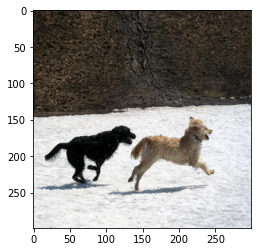

In [56]:
plt.imshow(get_image(train_list[0]))
img_decoder(enc_train[0])

We should also be able to apply the model to dev images and get reasonable captions:

['<START>',
 'a',
 'man',
 'in',
 'a',
 'white',
 'shirt',
 'and',
 'black',
 'pants',
 'is',
 'in',
 'a',
 'field',
 'of',
 'grass',
 '.',
 '<END>']

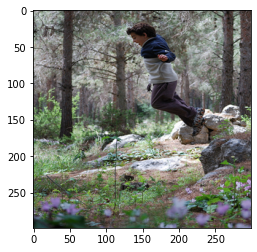

In [57]:
plt.imshow(get_image(dev_list[1]))
img_decoder(enc_dev[0])

## Part IV - Beam Search Decoder (24 pts)

We will modify the simple greedy decoder for the caption generator to use beam search. 
Instead of always selecting the most probable word, use a *beam*, which contains the n highest-scoring sequences so far and their total probability (i.e. the product of all word probabilities). I recommend that you use a list of `(probability, sequence)` tuples. After each time-step, prune the list to include only the n most probable sequences. 

Then, for each sequence, we compute the n most likely successor words. Append the word to produce n new sequences and compute their score. This way, you create a new list of n*n candidates. 

Then we Prune this list to the best n as before and continue until `MAX_LEN` words have been generated.

In [76]:
def img_beam_decoder(n, image_enc):
    
    res = [(0, ["<START>"])]
    
    image_encoding = img_encoder.predict(np.array([get_image(image_enc)]))[0]
    
    # while sentence length is less than 40, we run this loop
    while len(res[-1][1]) < 40:
        new_res = []
        
        # for every partial sentence in the list, we predict next n possible token
        for seq in res:
            
            # get encoded sentence
            inp = [0] * MAX_LEN
            sentence = seq[1]
            for i in range(len(sentence)):
                inp[i] = word_to_id[sentence[i]]
            
            # predict next n possible token
            out = model_2.predict([image_encoding.reshape((-1, 2048)), np.array(inp).reshape((-1, MAX_LEN))])
            out = out[0]
            
            index_array = np.argsort(out)[::-1][:n]
            
            
            prob_array = out[index_array]
            next_tokens = []
            for index in index_array:
                next_tokens.append(id_to_word[index])
            
            # output next n tokens to our sentence list
            for i in range(len(next_tokens)):
                new_res.append((seq[0]+np.log(prob_array[i]), seq[1]+[next_tokens[i]]))
            
            res = sorted(new_res, key=lambda x: x[0], reverse=True)[:n]
    
    prob, final_sentence = res[0][0], list(res[0][1])
    index = final_sentence.index("<END>")
    final_sentence = final_sentence[:index+1]
    return prob, final_sentence
            


Finally, we will show 5 development images, each with 1) their greedy output, 2) beam search at n=3 3) beam search at n=5. 

Greedy decoder: 
['<START>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'and', 'red', 'pants', 'is', 'rock', 'climbing', '.', '<END>']
--------------------------------------------
Beam search at n=3: 
['<START>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'red', 'pants', 'is', 'rock', 'climbing', '.', '<END>']
--------------------------------------------
Beam search at n=5: 
['<START>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'climbing', 'a', 'rock', '.', '<END>']
--------------------------------------------


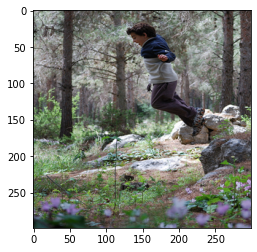

In [88]:
plt.imshow(get_image(dev_list[1]))
sentence_greedy = img_decoder(enc_dev[1])
print("Greedy decoder: ")
print(sentence_greedy)
print("--------------------------------------------")

prob, sentence_1 = img_beam_decoder(3, dev_list[1])
print("Beam search at n=3: ")
print(sentence_1)
print("--------------------------------------------")

prob, sentence_2 = img_beam_decoder(5, dev_list[1])
print("Beam search at n=5: ")
print(sentence_2)
print("--------------------------------------------")

Greedy decoder: 
['<START>', 'a', 'dog', 'and', 'a', 'dog', 'are', 'in', 'the', 'grass', '.', '<END>']
--------------------------------------------
Beam search at n=3: 
['<START>', 'a', 'dog', 'and', 'a', 'dog', 'in', 'the', 'grass', '.', '<END>']
--------------------------------------------
Beam search at n=5: 
['<START>', 'a', 'dog', 'is', 'in', 'the', 'grass', '.', '<END>']
--------------------------------------------


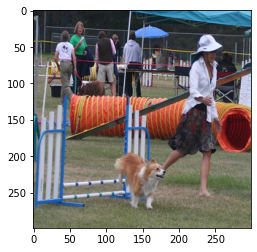

In [89]:
plt.imshow(get_image(dev_list[2]))
sentence_greedy = img_decoder(enc_dev[2])
print("Greedy decoder: ")
print(sentence_greedy)
print("--------------------------------------------")

prob, sentence_1 = img_beam_decoder(3, dev_list[2])
print("Beam search at n=3: ")
print(sentence_1)
print("--------------------------------------------")

prob, sentence_2 = img_beam_decoder(5, dev_list[2])
print("Beam search at n=5: ")
print(sentence_2)
print("--------------------------------------------")

Greedy decoder: 
['<START>', 'a', 'dog', 'and', 'a', 'dog', 'in', 'the', 'grass', '.', '<END>']
--------------------------------------------
Beam search at n=3: 
['<START>', 'a', 'dog', 'and', 'a', 'dog', 'are', 'in', 'the', 'grass', '.', '<END>']
--------------------------------------------
Beam search at n=5: 
['<START>', 'a', 'dog', 'and', 'a', 'dog', 'are', 'in', 'the', 'grass', '.', '<END>']
--------------------------------------------


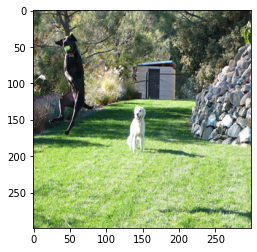

In [90]:
plt.imshow(get_image(dev_list[3]))
sentence_greedy = img_decoder(enc_dev[3])
print("Greedy decoder: ")
print(sentence_greedy)
print("--------------------------------------------")

prob, sentence_1 = img_beam_decoder(3, dev_list[3])
print("Beam search at n=3: ")
print(sentence_1)
print("--------------------------------------------")

prob, sentence_2 = img_beam_decoder(5, dev_list[3])
print("Beam search at n=5: ")
print(sentence_2)
print("--------------------------------------------")

Greedy decoder: 
['<START>', 'a', 'boy', 'in', 'a', 'bathing', 'suit', 'is', 'standing', 'on', 'the', 'beach', '.', '<END>']
--------------------------------------------
Beam search at n=3: 
['<START>', 'a', 'girl', 'in', 'a', 'bathing', 'suit', 'and', 'pink', 'shorts', 'is', 'standing', 'on', 'the', 'beach', '.', '<END>']
--------------------------------------------
Beam search at n=5: 
['<START>', 'a', 'girl', 'in', 'a', 'bathing', 'suit', 'and', 'pink', 'shorts', 'is', 'standing', 'on', 'the', 'beach', '.', '<END>']
--------------------------------------------


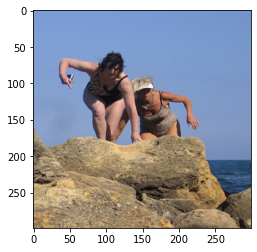

In [91]:
plt.imshow(get_image(dev_list[4]))
sentence_greedy = img_decoder(enc_dev[4])
print("Greedy decoder: ")
print(sentence_greedy)
print("--------------------------------------------")

prob, sentence_1 = img_beam_decoder(3, dev_list[4])
print("Beam search at n=3: ")
print(sentence_1)
print("--------------------------------------------")

prob, sentence_2 = img_beam_decoder(5, dev_list[4])
print("Beam search at n=5: ")
print(sentence_2)
print("--------------------------------------------")

Greedy decoder: 
['<START>', 'a', 'young', 'boy', 'in', 'a', 'blue', 'shirt', 'and', 'blue', 'shorts', 'is', 'in', 'a', 'grassy', 'field', '.', '<END>']
--------------------------------------------
Beam search at n=3: 
['<START>', 'a', 'young', 'boy', 'in', 'a', 'blue', 'shirt', 'and', 'blue', 'shorts', 'is', 'in', 'the', 'grass', '.', '<END>']
--------------------------------------------
Beam search at n=5: 
['<START>', 'a', 'little', 'boy', 'in', 'a', 'blue', 'shirt', 'is', 'playing', 'in', 'the', 'grass', '.', '<END>']
--------------------------------------------


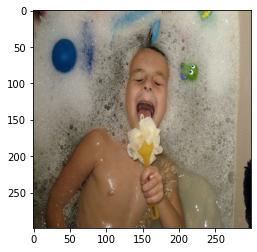

In [92]:
plt.imshow(get_image(dev_list[5]))
sentence_greedy = img_decoder(enc_dev[5])
print("Greedy decoder: ")
print(sentence_greedy)
print("--------------------------------------------")

prob, sentence_1 = img_beam_decoder(3, dev_list[5])
print("Beam search at n=3: ")
print(sentence_1)
print("--------------------------------------------")

prob, sentence_2 = img_beam_decoder(5, dev_list[5])
print("Beam search at n=5: ")
print(sentence_2)
print("--------------------------------------------")